# Power Spectral Density (PSD) and Instrument Self Noise

## License Information

This file is part of _hvsrpy_, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2024 Joseph P. Vantassel (joseph.p.vantassel@gmail.com)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_

_hvsrpy_ is an open-source Python package for performing horizontal-to-vertical spectral ratio (HVSR) processing of microtremor and earthquake recordings. _hvsrpy_ was developed by [Joseph P. Vantassel](https://www.jpvantassel.com/) with contributions from Dana M. Brannon under the supervision of Professor Brady R. Cox at The University of Texas at Austin. _hvsrpy_ continues to be developed and maintained by [Joseph P. Vantassel and his research group at Virginia Tech](https://geoimaging-research.org/).

## Citation

If you use _hvsrpy_ in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for hvsrpy, please use the citation tool on the hvsrpy
[archive](http://doi.org/10.5281/zenodo.3666956)._

## About this notebook

This notebook illustrates how _hvsrpy_ can be used for computing the power spectral density (PSD) using the method proposed by Welch (1967).

>Welch, P., (1967). The use of fast Fourier transform for the estimation of power spectra: a method based on time averaging over short, modified periodograms. IEEE Transactions on audio and electroacoustics, 15(2), pp.70-73.

The computed PSD is compared to the new high noise model (NHNM) and new low noise model (NLNM) proposed by Peterson (1993).
If you use the reference noise model's provided, please also cite Peterson (1993) to recognize their original work.

> Peterson, J., (1993). Observation and Modeling of Seismic Background Noise (Open-File Report No. 93–322). U.S. Geologic Survey, Albuquerque, New Mexico.

## Getting Started

1. Install _hvsrpy_, with `pip install hvsrpy`. More information on _pip_ can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Try analyzing the provided example. __(~10 minutes)__
3. Try your own files by changing the file names and insrument details below. __(~15 minutes)__

Happy Processing!

In [1]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import hvsrpy
from hvsrpy.instrument_response import InstrumentTransferFunction

plt.style.use(hvsrpy.HVSRPY_MPL_STYLE)

## Reference Noise Models


In [2]:
plot_reference_noise_models = True
fname_reference_high_noise_model = "./data/perterson_nhnm_psd.csv"
fname_reference_low_noise_model = "./data/perterson_nlnm_psd.csv"

if plot_reference_noise_models:
    reference_hnm = pd.read_csv(fname_reference_high_noise_model)
    reference_lnm = pd.read_csv(fname_reference_low_noise_model)

## Instrument Details

In [3]:
# SmartSolo | IGU-16HR 3C
poles = [
 (-22.211059+22.211059j),
 (-22.211059-22.211059j),
]
zeros= [
    (0+0j),
    (0+0j),
]
instrument_sensitivity = 2.576980e8
normalization_factor = 1
itf = InstrumentTransferFunction(poles=poles,
                                 zeros=zeros,
                                 instrument_sensitivity=instrument_sensitivity, 
                                 normalization_factor=normalization_factor)

## Input Data

In [4]:
fnames = [
    [f"./data/453016990.0001.{comp}.miniseed" for comp in "NEZ"]
]

print(f"Number of recordings: {len(fnames)}")
for fname_set in fnames:
    for file in fname_set:
        if not pathlib.Path(file).exists():
            raise FileNotFoundError(f"file {file} not found; check spelling.")
print("All files exists")

Number of recordings: 1
All files exists


## Power Spectral Density Preprocessing Settings

In [5]:
preprocessing_settings = hvsrpy.settings.PsdPreProcessingSettings()
preprocessing_settings.orient_to_degrees_from_north = 0.0
preprocessing_settings.filter_corner_frequencies_in_hz=(0.005, None)
preprocessing_settings.window_length_in_seconds = 60
preprocessing_settings.detrend = "linear"
preprocessing_settings.window_type_and_width = ('tukey', 0.1)
preprocessing_settings.instrument_transfer_function=itf
preprocessing_settings.differentiate=True

print("Preprocessing Summary")
print("-"*60)
preprocessing_settings.psummary()

Preprocessing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0rc7
orient_to_degrees_from_north             : 0.0
filter_corner_frequencies_in_hz          : (0.005, None)
window_length_in_seconds                 : 60
detrend                                  : linear
window_type_and_width                    : ('tukey', 0.1)
fft_settings                             : None
instrument_transfer_function             : InstrumentTransferFunction at 139668417626176
differentiate                            : True
preprocessing_method                     : psd


## Power Spectral Density Processing Settings

In [6]:
processing_settings = hvsrpy.settings.PsdProcessingSettings()
processing_settings.window_type_and_width=('tukey', 0.1)
processing_settings.smoothing=None

print("Processing Summary")
print("-"*60)
processing_settings.psummary()

Processing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0rc7
window_type_and_width                    : ('tukey', 0.1)
smoothing                                : None
fft_settings                             : None
handle_dissimilar_time_steps_by          : keeping_majority_time_step
processing_method                        : psd


## Calculate
---

In [7]:
srecords = hvsrpy.read(fnames)
srecords = hvsrpy.preprocess(srecords, preprocessing_settings)
psds = hvsrpy.process(srecords, processing_settings)

## Summarize PSD Results (Log-Scale)

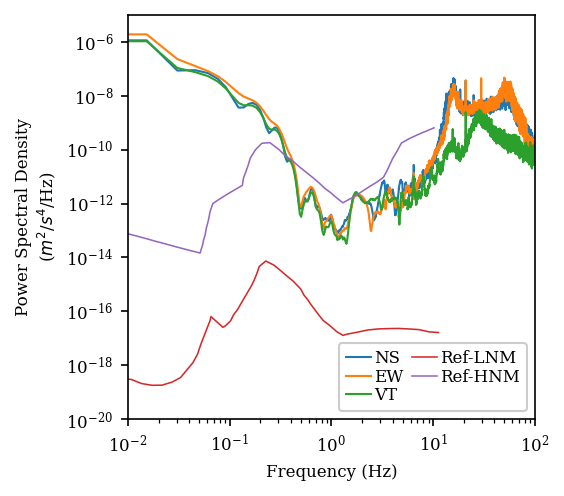

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)
for component, psd in psds.items():
    ax.plot(psd.frequency, psd.amplitude, label=f"{component.upper()}", lw=1)

if plot_reference_noise_models:
    ax.plot(reference_lnm["Frequency (Hz)"], reference_lnm["PSD (m**2/s**4/Hz)"], label="Ref-LNM")
    ax.plot(reference_hnm["Frequency (Hz)"], reference_hnm["PSD (m**2/s**4/Hz)"], label="Ref-HNM")

ax.legend(loc="upper right")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density\n" +r"($m^2$/$s^4$/Hz)")
ax.set_xlim(0.01, 100)
ax.set_ylim(1E-20, 1E-5)
ax.legend(loc="lower right", ncol=2)
plt.show()

## Summarize PSD Results (in decibels)

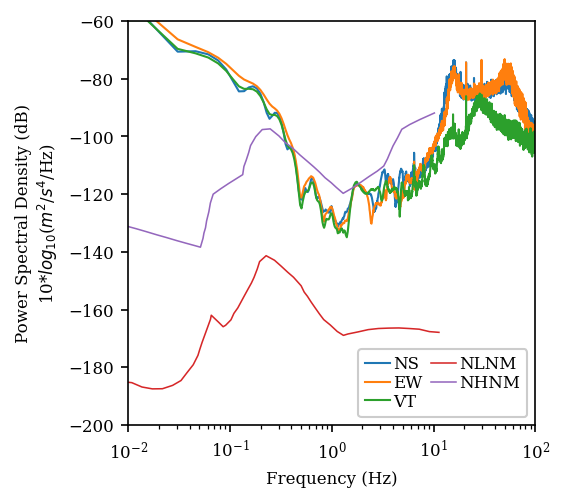

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)
for component, psd in psds.items():
    ax.plot(psd.frequency, 10*np.log10(psd.amplitude), label=f"{component.upper()}", lw=1)

if plot_reference_noise_models:
    ax.plot(reference_lnm["Frequency (Hz)"], 10*np.log10(reference_lnm["PSD (m**2/s**4/Hz)"]), label="NLNM")
    ax.plot(reference_hnm["Frequency (Hz)"], 10*np.log10(reference_hnm["PSD (m**2/s**4/Hz)"]), label="NHNM")

ax.legend(loc="lower right", ncol=2)
ax.set_xscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density (dB)\n" +r"10*$log_{10}$($m^2$/$s^4$/Hz)")
ax.set_xlim(0.01, 100)
ax.set_ylim(-200, -60)
plt.show()